In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

import tensorflow as tf 
from network import physicsNetwork
from initializer import initData, batchData
from optimizer import pinnOptimizer

In [2]:
import tensorflow as tf
import numpy as np

# Define t and x
t = np.linspace(0, 10, 11)
x = np.linspace(0, 10, 11)

# Stack t and x to form (tx) pairs
tx = np.stack([t, x], axis=1)

# Convert to TensorFlow tensor
tx_tf = tf.convert_to_tensor(tx, dtype=tf.float32)

# Define u and v as functions of t and x
def uv_fn(tx):
    t, x = tx[..., 0], tx[..., 1]
    u = t**2
    v = t**3
    return tf.stack([u, v], axis=-1)

# Compute the Jacobian using automatic differentiation
with tf.GradientTape(persistent=True) as tape:
    tape.watch(tx_tf)
    uv = uv_fn(tx_tf)

J = tape.batch_jacobian(uv, tx_tf)
sum_ = tf.reduce_sum(uv, axis = 0)
print(sum_)  # Convert to NumPy for readability


tf.Tensor([ 385. 3025.], shape=(2,), dtype=float32)


In [3]:
tf.reduce_sum(uv**2, axis = 1)

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([0.00000e+00, 2.00000e+00, 8.00000e+01, 8.10000e+02, 4.35200e+03,
       1.62500e+04, 4.79520e+04, 1.20050e+05, 2.66240e+05, 5.38002e+05,
       1.01000e+06], dtype=float32)>

In [4]:
uv[:,0]**2 + uv[:,1]**2

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([0.00000e+00, 2.00000e+00, 8.00000e+01, 8.10000e+02, 4.35200e+03,
       1.62500e+04, 4.79520e+04, 1.20050e+05, 2.66240e+05, 5.38002e+05,
       1.01000e+06], dtype=float32)>

# Initializing Collocation Point

In [5]:
def sechPulse(time, amplitude, pulse_width):
    time = time
    return amplitude/np.cosh(time/pulse_width)

In [6]:
T = 500
L = 5000
pulse_width = 100/T #ps
amplitude = 1
t_start = -5*pulse_width
t_end = 5*pulse_width

x_start = 0/L; #km
x_end = 5000/L

start_point = np.array([t_start, x_start])
final_point = np.array([t_end, x_end])

num_points = 5000
num_label = 100

In [7]:
gen_data = initData()

t_initial = gen_data.init_points(t_end, t_start, num_label)
x_boundary = gen_data.init_points(x_end, x_start, num_label)

#collocation point 
col_point = gen_data.init_points(final_point, start_point, num_points)

#initial condition (x = 0)
init_point = np.zeros((num_label, 2))
init_point[..., 0] = t_initial.reshape(-1)
init_point[..., 1] = np.zeros_like(init_point[..., 1])

u_init = sechPulse(init_point[..., 0], amplitude, pulse_width) #real part
u_init = np.expand_dims(u_init, axis=1)
v_init = np.zeros_like(u_init) #imaginary part

#lower boundary condition (t = t_init)
lower_point = np.zeros((num_label, 2))
lower_point[..., 0] = np.ones_like(lower_point[..., 0])*t_start
lower_point[..., 1] = x_boundary.reshape(-1)

u_lower = np.zeros_like(lower_point[..., 0])
u_lower = np.expand_dims(u_lower, axis=1)
v_lower = np.zeros_like(u_lower)

#upper boundary condition (t = t_f)
upper_point = np.zeros((num_label, 2))
upper_point[..., 0] = np.ones_like(upper_point[..., 0])*t_end
upper_point[..., 1] = x_boundary.reshape(-1)

u_upper = np.zeros_like(upper_point[..., 0])
u_upper = np.expand_dims(u_upper, axis=1)
v_upper = np.zeros_like(u_upper)

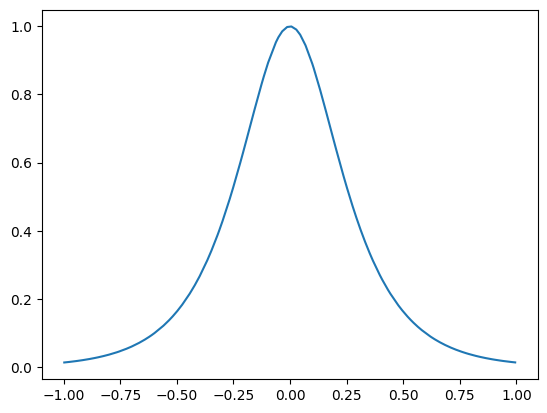

In [8]:
a = np.sort(init_point[..., 0].reshape(-1))
plt.plot(a, sechPulse(a, amplitude, pulse_width))

## Initialize and Batch Data

In [11]:
preparation = batchData()
preparation.add_collocation_point(col_point)
preparation.add_labelled_data(init_point, u_init, v_init, 'initCond')
preparation.add_labelled_data(lower_point, u_lower, v_lower, 'lowerBound')
preparation.add_labelled_data(upper_point, u_upper, v_upper, 'upperBound')

batched_data = preparation.batch_data(500)
keys = preparation.get_keys()

## test

In [10]:
data = iter(batched_data['col_point'])
myBatch = next(data)

In [11]:
model = physicsNetwork.build(layers = [64,64,64])

In [12]:
alpha = 1 
gamma = 1 
beta2 = 1
optimizer = pinnOptimizer(model, batched_data, T, L, alpha, beta2, gamma)

In [13]:
loss = optimizer.compute_residue(myBatch[0])

scalar shape: Tensor("Shape_2:0", shape=(2,), dtype=int32)


In [14]:
loss 

<tf.Tensor: shape=(500, 2), dtype=float32, numpy=
array([[-5.74181927e-03, -1.88294556e-02],
       [ 3.90052423e-02,  7.78897386e-03],
       [ 4.25484590e-02, -8.22625530e-04],
       [-2.08733454e-02, -1.47625851e-02],
       [ 9.68730599e-02,  1.20596401e-02],
       [ 6.58947825e-02,  7.60222692e-03],
       [-5.03654517e-02, -1.98401306e-02],
       [ 1.09682776e-01,  1.95672158e-02],
       [ 5.01266867e-02,  1.00781890e-02],
       [ 1.03969410e-01,  1.36148781e-02],
       [ 6.65774271e-02,  1.29400976e-02],
       [ 6.74733892e-02,  1.33483661e-02],
       [ 3.79941948e-02,  2.73063662e-03],
       [ 2.37135403e-02, -3.23277595e-03],
       [-6.12344816e-02, -1.65983476e-02],
       [ 7.42256865e-02,  7.60883465e-03],
       [-5.47243953e-02, -1.91178154e-02],
       [ 5.23519218e-02,  7.58898258e-03],
       [ 7.50902519e-02,  7.85953831e-03],
       [-5.18233329e-02, -1.35411853e-02],
       [-4.44180444e-02, -2.37231869e-02],
       [ 8.49842466e-03, -4.48870414e-04],
    

# Initializing Model

In [12]:
model = physicsNetwork.build(layers = [64,64,64])

# Fit Model

In [13]:
alpha = 1 
gamma = 1 
beta2 = 1
optimizer = pinnOptimizer(model, batched_data, T, L, alpha, beta2, gamma)
optimizer.fit(2)

Epoch 1/2


Labelled Loss: 3.3168e-02: 100%|██████████| 1/1 [00:35<00:00, 35.15s/batch]


Residue Loss : 0.0010; Labelled Loss : 0.0332
Epoch 2/2


Labelled Loss: 3.3120e-02: 100%|██████████| 1/1 [01:07<00:00, 67.40s/batch]

Residue Loss : 0.0062; Labelled Loss : 0.0331


In [14]:
t_array = np.linspace(t_start, t_end, 100)
zlocs = np.linspace(x_start, x_end, 500)
T, Z = np.meshgrid(t_array, zlocs)
tZ = np.stack((T.flatten(), Z.flatten()), axis = -1)

result = optimizer.model.predict(tZ)

result_u = result[:, 0].reshape(Z.shape)
result_v = result[:, 1].reshape(Z.shape)


1563/1563 [==============================] - 1s 711us/step


In [15]:
result_P = (result_u**2 + result_v**2)

In [16]:
result_P

array([[3.6894045e-05, 4.6147208e-05, 6.0397084e-05, ..., 1.0383401e-05,
        3.3426670e-06, 3.2424934e-05],
       [3.6655438e-05, 4.5885026e-05, 6.0103735e-05, ..., 1.0629589e-05,
        3.1872646e-06, 3.1844920e-05],
       [3.6414931e-05, 4.5621011e-05, 5.9812275e-05, ..., 1.0880339e-05,
        3.0375838e-06, 3.1273881e-05],
       ...,
       [3.1648866e-05, 2.5927144e-05, 2.0404404e-05, ..., 3.5213052e-05,
        6.0735729e-06, 2.7755368e-06],
       [3.1940224e-05, 2.6168858e-05, 2.0586202e-05, ..., 3.5049812e-05,
        6.0347834e-06, 2.8486306e-06],
       [3.2234573e-05, 2.6411428e-05, 2.0768888e-05, ..., 3.4883353e-05,
        5.9980794e-06, 2.9232547e-06]], dtype=float32)

# Visualize Data

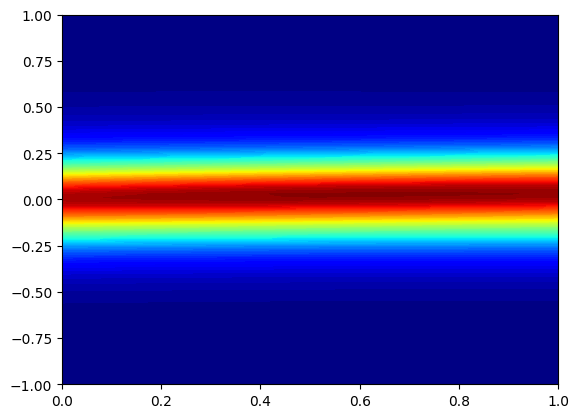

In [17]:
plt.contourf(Z,T, result_P, 100, cmap = 'jet')

In [21]:
from matplotlib import cm

Text(0.5, 0.92, 'Propagation of Pulse in Non-Linear Optical Fiber via PINN')

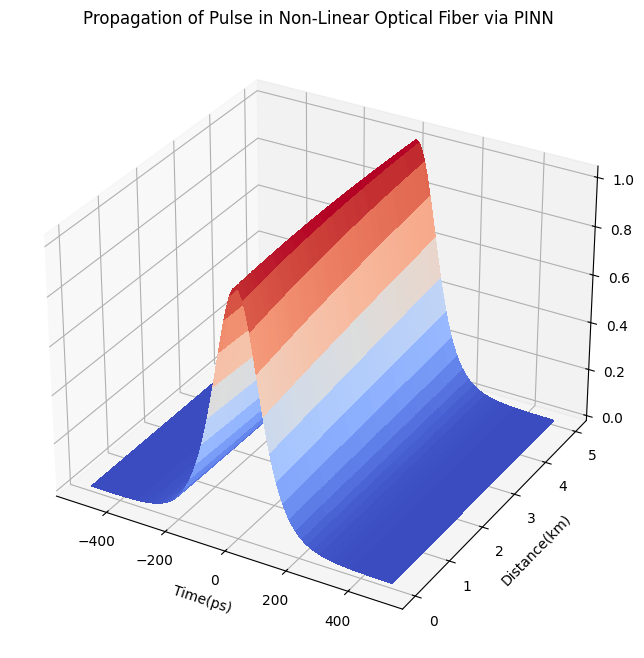

In [26]:
fig, ax = plt.subplots(figsize = (10,8), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(T*500, Z*5, result_P, cmap = cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('Time(ps)')
ax.set_ylabel('Distance(km)')
ax.set_title('Propagation of Pulse in Non-Linear Optical Fiber via PINN')

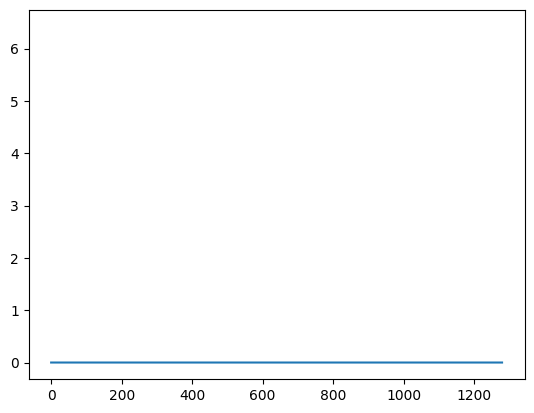

In [43]:
fig, ax = plt.subplots()
line, = ax.plot(result_P[0])

def init():
    line.set_ydata(result_P[0])
    return line,

def update(frame):
    line.set_ydata(result_P[frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames = range(result_P.shape[0]), init_func = init, blit = True)
HTML(ani.to_jshtml())

In [41]:
nrange = 200
cutoff = -30

def plotPulse2D(matrix, t, zlocs, nrange, cutoff):
    fig,ax = plt.subplots()
    ax.set_title('Pulse Evolution (dB scale)')
    thisT = t[int(len(t)/2-nrange):int(len(t)/2+nrange)]*1e12 
    thisZ = zlocs 
    T, Z = np.meshgrid(thisT, thisZ)

    matrix = matrix[:, int(len(t)/2-nrange):int(len(t)/2+nrange)]
    P = matrix/np.max(matrix)

    P[P<1e-100] = 1e-100
    P_dB = 10*np.log10(P)
    P_dB[P_dB<cutoff] = cutoff

    surf = ax.contourf(T,Z,P_dB, levels = 40)
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('Distance (m)')
    cbar = fig.colorbar(surf, ax = ax)
    plt.show()